In [2]:
import os
import torch
import train
import ml4gw
import train.priors
import train.data.datasets.flow
import train.data.waveforms.generator.cbc
import ml4gw.waveforms 
import ml4gw.distributions
import ml4gw.transforms
import ml4gw.dataloading
from pathlib import Path
import matplotlib.pyplot as plt

In [3]:
dec = ml4gw.distributions.Cosine()
psi = torch.distributions.Uniform(0, 3.14)
phi = torch.distributions.Uniform(-3.14, 3.14)
waveform_sampler = train.data.waveforms.generator.cbc.FrequencyDomainCBCGenerator(
    approximant=ml4gw.waveforms.IMRPhenomD(),
    f_min=20,
    f_max=1024,
    waveform_arguments={'f_ref': 40},
    num_test_waveforms=1,
    num_val_waveforms=1,
    parameter_sampler=train.priors.cbc_prior,
    num_fit_params=100000,
    inference_params=["chirp_mass", "mass_ratio", "distance", "phic",  "inclination", "dec", "psi", "phi"],
    sample_rate=2048,
    dec=dec,
    psi=psi,
    phi=phi, 
    duration=4,
    padding=0,
    ringdown_duration=0.5,
)

datamodule = train.data.datasets.flow.FlowDataset(
    data_dir=Path(os.environ["AMPLFI_DATADIR"]),
    inference_params=["chirp_mass", "mass_ratio", "distance", "phic",  "inclination", "dec", "psi", "phi"],
    highpass=25,
    sample_rate=2048,
    kernel_length=3,
    fduration=1,
    psd_length=10,
    fftlength=2,
    batches_per_epoch=1,
    batch_size=1,
    ifos=["H1", "L1"],
    min_valid_duration=10000.0,
    waveform_sampler=waveform_sampler,
)

2024-09-12 12:54:18,243 - root - INFO - Downloading data to /home/exouser/Documents/ligo/my-first-run/data


In [5]:
world_size, rank = datamodule.get_world_size_and_rank()
train_fnames, val_fnames = datamodule.train_val_split()
[background] = datamodule.load_background([train_fnames[0]])
datamodule._logger = datamodule.get_logger(world_size, rank)
datamodule.build_transforms("fit")
dataset = ml4gw.dataloading.InMemoryDataset(
                background,
                kernel_size=int(datamodule.hparams.sample_rate * datamodule.sample_length),
                batch_size=datamodule.hparams.batch_size,
                coincident=False,
                batches_per_epoch=datamodule.hparams.batches_per_epoch,
                shuffle=True,
            )
dataloader = torch.utils.data.DataLoader(
            dataset, num_workers=2
        )
[X] = next(iter(dataloader))
# X.to("cuda")

cross, plus, parameters = datamodule.waveform_sampler.sample(X)
strain, parameters = datamodule.inject(X, cross, plus, parameters)

2024-09-12 12:54:44,884 - AmplfiDataset - INFO - Building torch Modules and transferring to device


2024-09-12 12:54:44,909 - AmplfiDataset - INFO - Fitting standard scaler to parameters


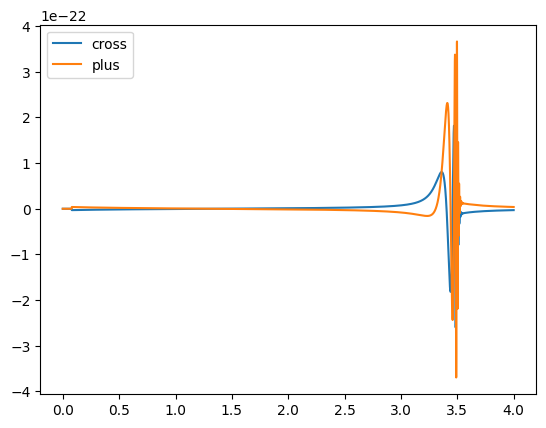

In [6]:
import numpy as np
time = np.arange(0, 4, 1/waveform_sampler.sample_rate)
plt.plot(time, cross[0], label="cross")
plt.plot(time, plus[0], label="plus")
# plt.xlim(2.4, 3.01)
plt.legend()

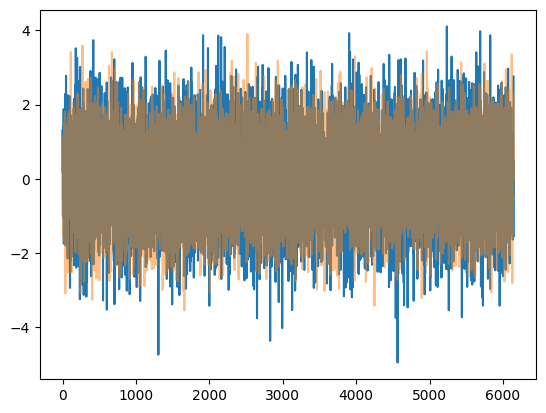

In [10]:
plt.plot(strain[0][0], label="L1")
plt.plot(strain[0][1], label="H1", alpha=0.5)

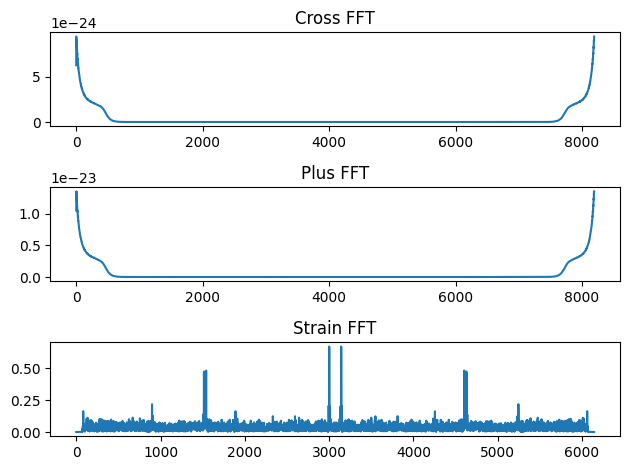

In [25]:
cross_fft = torch.fft.fft(cross[0]/waveform_sampler.sample_rate)
plus_fft = torch.fft.fft(plus[0]/waveform_sampler.sample_rate)
strain_fft = torch.fft.fft(strain[0][0]/waveform_sampler.sample_rate)
plt.figure()
plt.subplot(3, 1, 1)
plt.plot(torch.abs(cross_fft))
plt.title("Cross FFT")
plt.subplot(3, 1, 2)
plt.plot(torch.abs(plus_fft))
plt.title("Plus FFT")
plt.subplot(3, 1, 3)
plt.plot(torch.abs(strain_fft))
plt.title("Strain FFT")
plt.tight_layout()
plt.show()